# Comparison with Auclert et al Jacobian Computation 

In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__, ".."))
using MicroRisks
using DelimitedFiles
using CairoMakie

  Activating project at `~/Github/micro_risks`


In [2]:
# Household
h = let     
    
    ar1 = 0.966
    sigmaP = 0.5 * (1 - 0.966^2)^(1/2)  # sqrt(0.0384)/(1.2)
    sigmaIID = 0.0 #.5 # sqrt(0.0522)/(1.2)
    P, z_vals = calibration(5, 1, ar1, sigmaP, sigmaIID)

    # This the income process implied by Auclert et al's code.
    P_Auclert = [
        0.933714431521  0.06459062191600005  0.001675545126000003  1.931791600000005e-05  8.352100000000029e-08;
        0.016147655479000014  0.934552204084  0.048457454874000036  0.0008378560840000014  4.829479000000013e-06;
        0.0002792575210000005  0.03230496991600003  0.934831545126  0.03230496991600003  0.0002792575210000005;
        4.829479000000013e-06  0.0008378560840000015  0.04845745487400005  0.934552204084  0.016147655479000014;
        8.352100000000029e-08  1.931791600000005e-05  0.001675545126000003  0.06459062191600005  0.933714431521
    ]
    
    z_vals_Auclert = [ 
        0.32506854402390545,
        0.5359474228930929,
        0.883627915977697,
        1.4568561402539593,
        2.401949706452274,
    ]

    @assert P ≈ P_Auclert 
    @assert z_vals ≈ z_vals_Auclert

    ies = 1 / 2.0
    crra = 2.0
    β = 0.987475
    u = EZ(ies = ies, ra = crra, β = β)
    v = MicroRisks.FixedLabor()
    Household(u = u, a_grid = grid(stop = 30.0, length = 500, scale = :log),
        v = v, P = P, z_grid = z_vals)
end

# Using the same a_grid function as in the Auclert et al version: 
a_grid = readdlm(joinpath(@__DIR__, "assets_grid.csv"), ',')
h.a_grid .= a_grid


# Technology
t = let
    δ = 0.12
    A = 0.748057
    α = 0.3
    μ = 1.0
    CobbDouglasTechnology(α = α, A = A, δ = δ, μ = μ)
end


@time e_init = stationary_laissez_faire(h, t; r_range = (-0.09, 0.02), 
    verbose = true, hh_problem_kwargs = (; verbose= false, max_iters = 20_000))

error: -17.717429028435497 r:-0.09 w:1.2404411654263574 n:1.0 k:17.72058807751939 a:0.0031590490838945226
error: 27.403687219731207 r:0.02 w:0.6410014006758697 n:1.0 k:1.9622491857424587 a:29.365936405473665
error: 2.082205668642469 r:0.0 w:0.684779041538282 n:1.0 k:2.4456394340652925 a:4.5278451027077615
error: 1.2486414350935298 r:-0.0019696353250653275 w:0.6896532952786067 n:1.0 k:2.504149663440912 a:3.7527910985344417
error: 0.2192797461398759 r:-0.005163176562155522 w:0.6978084213664882 n:1.0 k:2.604223480424605 a:2.823503226564481
error: -0.2951565224725128 r:-0.007237469827498948 w:0.703281075996377 n:1.0 k:2.6729284538572857 a:2.377771931384773
error: -0.0028535549094175217 r:-0.0060107673748190284 w:0.7000274442491828 n:1.0 k:2.6319307088203328 a:2.6290771539109152
error: 7.547978765565233e-6 r:-0.00599940838410876 w:0.6999975503004928 n:1.0 k:2.6315560812139154 a:2.631563629192681
error: -7.554568748346924e-6 r:-0.005999468317235271 w:0.6999977080179357 n:1.0 k:2.631558057613

Stationary Equilibrium. Household: EZ(ra=2.0, ies=0.5, β=0.987475), v=FixedLabor(n=1.0), z_grid=[0.32506854393291457..2.401949707118008], P=[..], a_grid = 0.0..500pts..30.0, Technology: α=0.3, A=0.748057, δ=0.12, r=-0.005999438335140608, w=0.6999976291183277, T=0.0, a=2.631557069481076, k=2.6315570689010848, b=0.0, n=1.0

In [3]:
@assert is_pol_valid(e_init)

In [4]:
# Reading the jacobian from Auclert et al simulations:
mat = readdlm(joinpath(@__DIR__, "jacobian_SSJ_toolkit.csv"), ',');

In [6]:
# Computing ours
@time jac = jacobian_column([10, 200, 500], e_init, cap_t = 1001, cap_s = 500, ΔR = 1e-4, ΔT = 0.0);

  1.926568 seconds (848.38 k allocations: 312.256 MiB, 2.36% gc time, 26.84% compilation time)


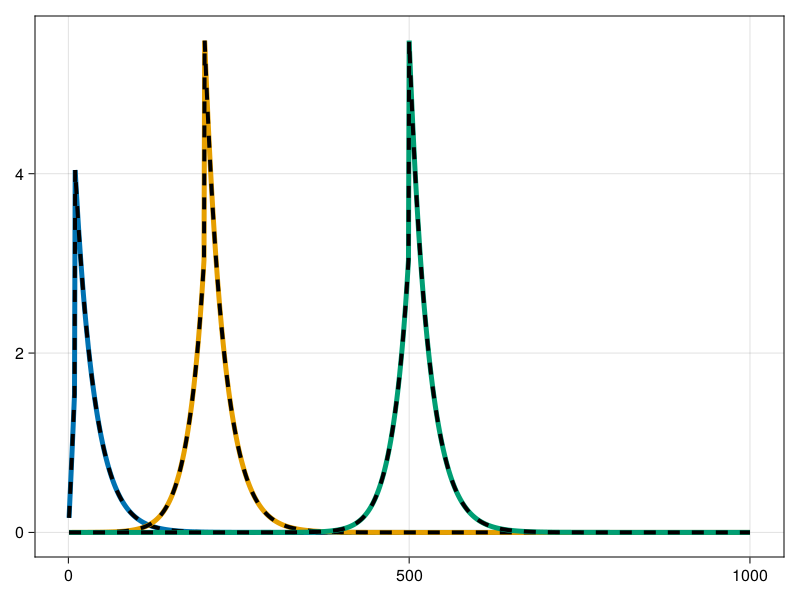

In [7]:
# Comparing in a figure
let 
    fig, ax = lines( jac[1][2:end], linewidth = 5)
    lines!(ax, mat[:, 10], linewidth = 4, linestyle = :dash, color = :black)

    lines!(ax, jac[2][2:end], linewidth = 5)
    lines!(ax, mat[:, 200], linewidth = 4, linestyle = :dash, color=:black)

    lines!(ax, jac[3][2:end], linewidth = 5)
    lines!(ax, mat[:, 500], linewidth = 4, linestyle = :dash, color=:black)
    fig
end 

In [7]:
extrema(mat[1:end, 10] .- jac[1][2:end])
extrema(mat[1:end, 200] .- jac[2][2:end])
extrema(mat[1:end, 500] .- jac[3][2:end])

(-0.00017486499031926783, 5.6958556528541315e-6)